In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import nbgwas
from nbgwas.nbgwas import Nbgwas

In [3]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
nbgwas.__version__

'0.3.1'

# Gene Level Summary

In [5]:
%%time

gene_level_summary_file = '../data/scz/gene_level_summary_stats_pmid_25056061.txt'
g = Nbgwas().read_gene_table(gene_level_summary_file)

CPU times: user 87.8 ms, sys: 43.2 ms, total: 131 ms
Wall time: 297 ms


In [6]:
%%time

g.read_nx_pickle_file('../data/networks/pcnet.pkl')

CPU times: user 4.77 s, sys: 3.54 s, total: 8.31 s
Wall time: 16.5 s


In [7]:
g.gene_level_summary.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
0,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
1,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
2,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
3,HIST1H2AL,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
4,HIST1H1B,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


In [9]:
from py2cytoscape import cyrest

In [31]:
%%time 

g.cache_network_data() #this loads the adjacency matrix and laplacian matrix in memory
                       #Makes subsequent diffusions very fast

CPU times: user 1min 10s, sys: 2min 17s, total: 3min 28s
Wall time: 4min 51s


In [32]:
g.convert_to_heat(method='binarize', name='Binary') 

In [34]:
g.diffuse(method='random_walk', alpha=0.2, heat='Binary', result_name='Test')

In [35]:
g.heat.head()

,Binary,Test
TCF4,1.0,0.231018
HIST1H4C,1.0,0.224937
HIST1H2BC,1.0,0.224309
HIST1H2BN,1.0,0.222505
HIST1H4J,1.0,0.222313


In [37]:
%%time 

g.diffuse(method='random_walk', alpha=0.2, heat="Binary", result_name='a=0.2')
g.diffuse(method='random_walk', alpha=0.5, heat="Binary", result_name='a=0.5')
g.diffuse(method='random_walk', alpha=0.8, heat="Binary", result_name='a=0.8')

CPU times: user 3.99 s, sys: 938 ms, total: 4.92 s
Wall time: 4.98 s


In [38]:
g.heat.head()

,Binary,Test,a=0.2,a=0.5,a=0.8
TCF4,1.0,0.231018,0.231018,0.539516,0.823535
HIST1H2BC,1.0,0.224309,0.224309,0.526892,0.814440
HIST1H4C,1.0,0.224937,0.224937,0.526994,0.814388
ZKSCAN3,1.0,0.218205,0.218205,0.524266,0.814367
HIST1H4J,1.0,0.222313,0.222313,0.525601,0.813903


In [39]:
g.annotate_network(values="all")

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xa73c1be48>)

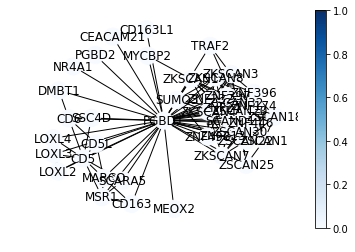

In [40]:
g.get_subgraph("PGBD1", name="PGBD1").view(name="PGBD1", attributes="Heat")

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xac500b1d0>)

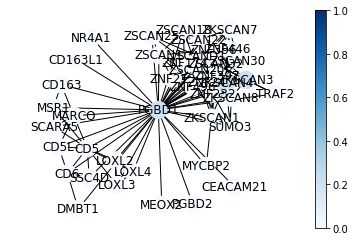

In [41]:
g.view(name="PGBD1", attributes="a=0.2")

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xaca3a7eb8>)

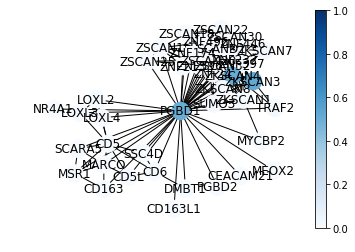

In [42]:
g.view(name="PGBD1", attributes="a=0.5")

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xaca323860>)

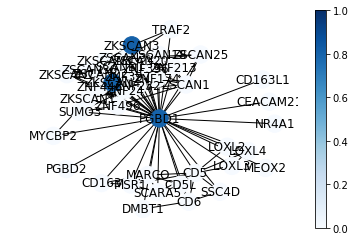

In [43]:
g.view(name="PGBD1", attributes="a=0.8")

In [44]:
g.to_ndex(name="PGBD1")

'http://dev2.ndexbio.org/v2/network/7af68d09-b231-11e8-a148-0660b7976219'

# SNP Level Summary

In [ ]:
del g

In [ ]:
%%time 

snp_level_summary_file = '../data/scz/snp_level_summary_stats_pmid_25056061.txt'
protein_coding_file = '../data/glist-hg18_proteinCoding.txt'

g = Nbgwas() \
    .read_snp_table(snp_level_summary_file) \
    .read_protein_coding_table(protein_coding_file)

In [ ]:
%%time 

g.get_network_from_ndex()

In [ ]:
g.network

In [ ]:
g.snp_level_summary.head()

In [ ]:
g.protein_coding_table.head()

In [ ]:
%%time

g.assign_pvalues(window_size=10000)

In [ ]:
g.gene_level_summary.head()

In [ ]:
g.convert_to_heat()

In [ ]:
g.heat.head()